In [1]:
!pip install --upgrade qiskit==1.3.1 qiskit-machine-learning==0.8.2 pylatexenc qiskit_algorithms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.6/231.6 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 4.9 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=e308adeaa8c8cb5b3943d7b0de52b642594dbbddf3a1554735b54c4aab1617d9
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703adf4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.circuit.library import U3Gate, ZZFeatureMap, ZFeatureMap, RealAmplitudes
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator
from qiskit.circuit import Gate, Parameter, ParameterVector
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit.primitives import Sampler, Estimator
from qiskit_machine_learning.optimizers import COBYLA, SPSA, L_BFGS_B
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pickle import load
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


0


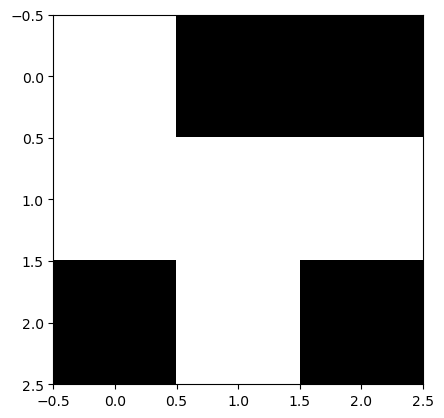

In [2]:
with open('./dataset.obj',"rb") as f:
    dataset_loaded = load(f)
plt.imshow(dataset_loaded[1][0],cmap="gray")
print(dataset_loaded[0][1])

In [3]:
data = np.array([x[0].flatten() for x in dataset_loaded])
labels = np.array([x[1] for x in dataset_loaded])
if data.dtype == bool:
    data = data.astype(np.float32)
data = (data - np.min(data)) / (np.max(data) - np.min(data))
print(len(data))

104


In [4]:
for i in range(len(data)):
  if labels[i] == 0:
    labels[i] = -1
print(labels)

[-1  1  1  1 -1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1 -1  1
  1  1 -1  1  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1 -1  1  1 -1 -1 -1  1
  1  1 -1  1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1  1  1  1  1 -1
 -1  1 -1 -1  1 -1  1  1  1 -1  1 -1  1  1 -1  1 -1  1 -1  1  1 -1 -1 -1
  1 -1  1  1 -1  1 -1  1]


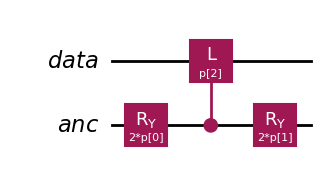

In [5]:
# Residual block with two trainable rotations (index added to avoid param conflicts)
def residual_block_r2(l_gate: Gate, params, idx):
    anc = QuantumRegister(1, 'anc')
    data = QuantumRegister(1, 'data')
    qc = QuantumCircuit(data, anc, name="R2_block")


    qc.ry(2 * params[idx], anc[0])
    controlled_l = l_gate.control(1)
    qc.append(controlled_l, [anc[0], data[0]])
    qc.ry(2 * params[idx + 1], anc[0])

    return qc


# Feature encoding using residual and Ry blocks
params = ParameterVector("p", 3)
l_circuit = QuantumCircuit(1)
l_circuit.ry(params[2], 0)
l_gate = l_circuit.to_gate(label="L")
qc = residual_block_r2(l_gate, params, 0)
qc.draw("mpl")

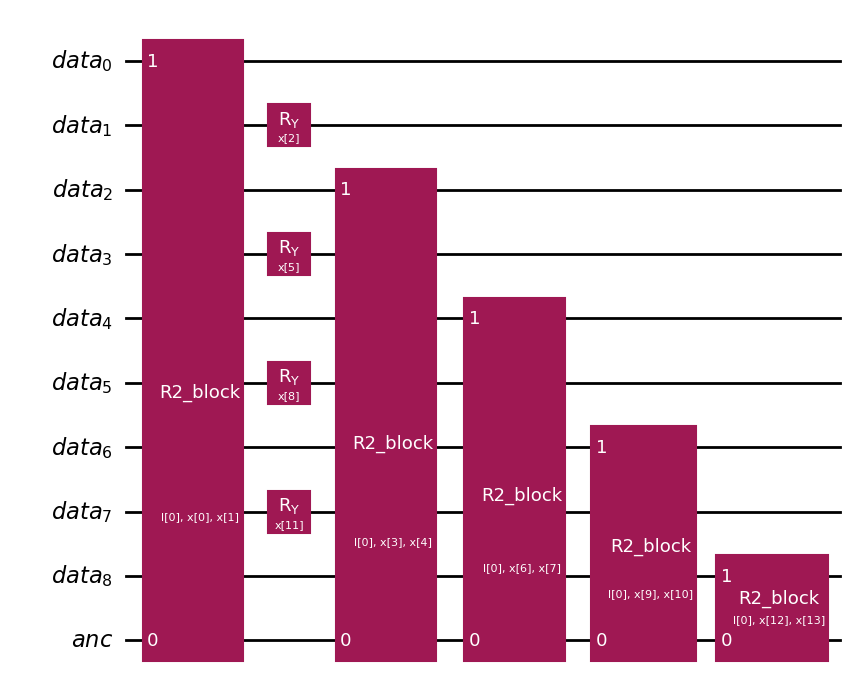

In [6]:
# Alternating feature map with R2 and Ry
def alternating_encoding_with_r2(n_qubits, ancilla, param_vec, l_param):
    data = QuantumRegister(n_qubits, 'data')
    qc = QuantumCircuit(data, ancilla, name = "Residual Layer")

    # Define L gate: U(x) = Ry(x)
    l_circuit = QuantumCircuit(1)
    l_circuit.ry(l_param[0], 0)
    l_gate = l_circuit.to_gate(label="L")

    p_idx = 0

    for i in range(n_qubits):
        if i % 2 == 0:
            # Apply R2 block
            r2 = residual_block_r2(l_gate, param_vec, p_idx)
            qc.append(r2, [ancilla[0], data[i]])
            p_idx += 2
        else:
            # Apply simple Ry
            qc.ry(param_vec[p_idx], data[i])
            p_idx += 1

    return qc

# Example usage
ancilla = QuantumRegister(1, 'anc')
params = ParameterVector("x", 20)
l_params = ParameterVector("l", 1)
circ = alternating_encoding_with_r2(9, ancilla, params, l_params)
circ.draw("mpl")

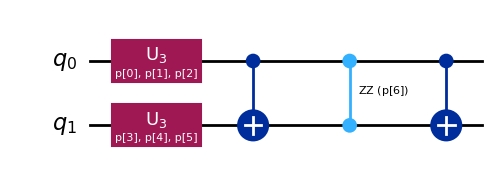

In [7]:
# Define convolutional layer
def conv_layer(qubits, weight_params, idx):
    qc = QuantumCircuit(len(qubits), name="Convolution")

    for i, q in enumerate(qubits):
        theta, phi, lam = weight_params[idx], weight_params[idx + 1], weight_params[idx+2]
        idx += 3
        qc.append(U3Gate(theta, phi, lam), [q])
    for i in range(len(qubits) - 1):
        qc.cx(i, i+1)
        qc.rzz(weight_params[idx], i,  i+1)
        qc.cx(i, i+1)
    return qc


# qubits = list(range(2))
qubits = [0,1]
params = ParameterVector("p", 7)  # 4*3 (for U3) + 1 (for ZZ)
conv = conv_layer(qubits, params, 0)
conv.draw("mpl")

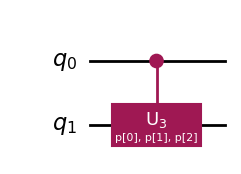

In [8]:
# Define pooling layer
def pooling_layer(ctrl, tgt, params):
    qc = QuantumCircuit(2, name="Pooling")
    u3_gate = U3Gate(*params)
    cu3 = u3_gate.control(1)
    qc.append(cu3, [0, 1])
    return qc

pool_params = ParameterVector("p", 3)
pool_circ = pooling_layer(0, 1, pool_params)
pool_circ.draw("mpl")

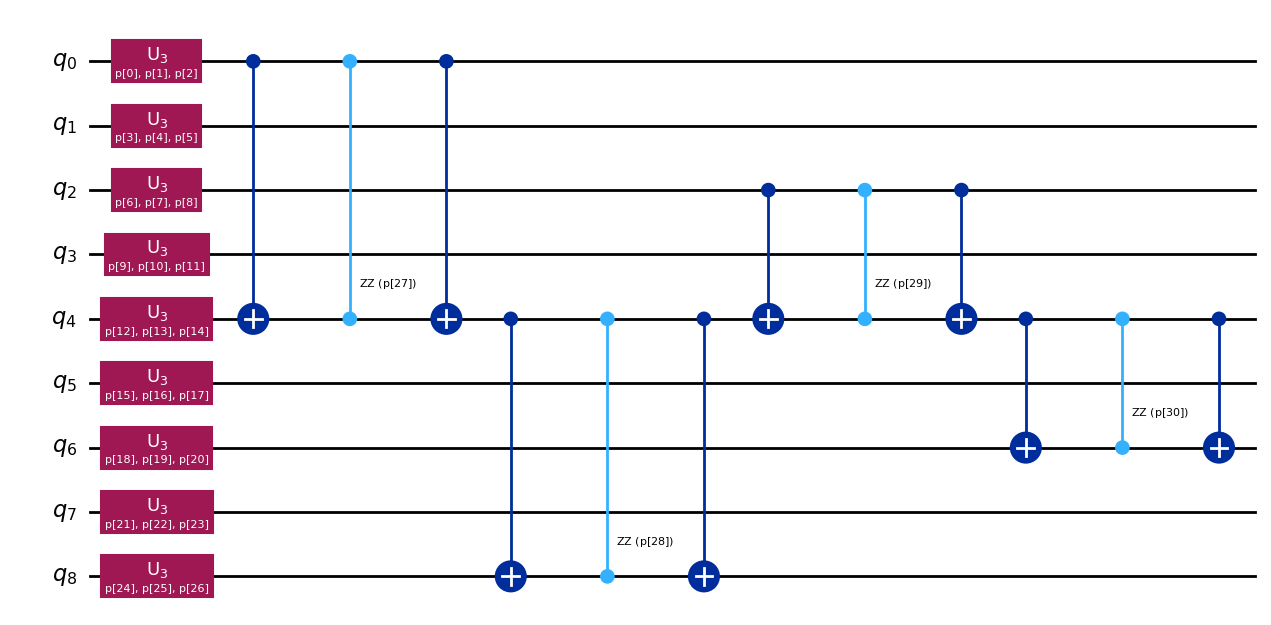

In [25]:
def diagonal_conv_layer(qubits, weight_params, idx):
    """
    Apply diagonal convolution on a 3x3 block of qubits.
    
    Args:
        qubits (list): List of 9 qubit indices, ordered row-wise.
        weight_params (list): Parameters for gates.
        idx (int): Current index in weight_params.
    
    Returns:
        QuantumCircuit: The convolution layer.
    """
    qc = QuantumCircuit(len(qubits), name="DiagonalConv")

    # Apply parameterized single-qubit rotations
    for i, q in enumerate(qubits):
        theta, phi, lam = weight_params[idx], weight_params[idx + 1], weight_params[idx + 2]
        idx += 3
        qc.append(U3Gate(theta, phi, lam), [q])

    # Apply diagonal entanglement
    diagonals = [(0, 4), (4, 8), (2, 4), (4, 6)]
    for (q1, q2) in diagonals:
        qc.cx(q1, q2)
        qc.rzz(weight_params[idx], q1, q2)
        qc.cx(q1, q2)
        idx += 1

    return qc

# qubits = list(range(2))
qubits = list(range(9))
params = ParameterVector("p", 31)  # 4*3 (for U3) + 1 (for ZZ)
dconv = diagonal_conv_layer(qubits, params, 0)
dconv.draw("mpl")

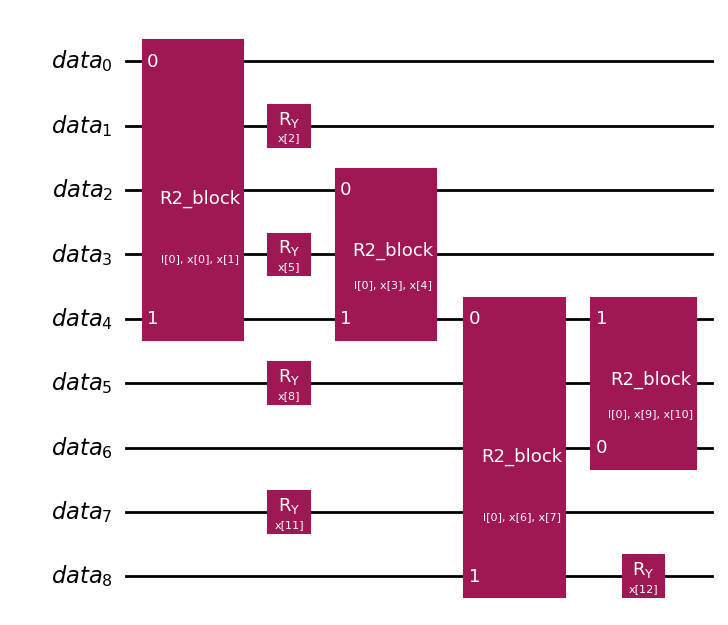

In [30]:
def alternating_encoding_with_diagonal_residual(n_qubits, param_vec, l_param):
    data = QuantumRegister(n_qubits, 'data')
    qc = QuantumCircuit(data, name="Residual Layer Diagonal")

    # Define L gate: U(x) = Ry(x)
    l_circuit = QuantumCircuit(1)
    l_circuit.ry(l_param[0], 0)
    l_gate = l_circuit.to_gate(label="L")

    p_idx = 0

    # Define diagonal pairs for a 3x3 grid
    diagonal_pairs = [(0, 4), (4, 8), (2, 4), (6,4)]

    for i in range(n_qubits):
        if any(i == pair[0] for pair in diagonal_pairs):
            # Find pair
            pair = next(p for p in diagonal_pairs if p[0] == i)
            # Apply R2 block between data[i] and data[j]
            r2 = residual_block_r2(l_gate, param_vec, p_idx)
            qc.append(r2, [data[pair[0]], data[pair[1]]])
            p_idx += 2
        else:
            # Apply simple Ry
            qc.ry(param_vec[p_idx], data[i])
            p_idx += 1

    return qc

# Example usage
params = ParameterVector("x", 13)
l_params = ParameterVector("l", 1)
circ = alternating_encoding_with_diagonal_residual(9, params, l_params)
circ.draw("mpl")

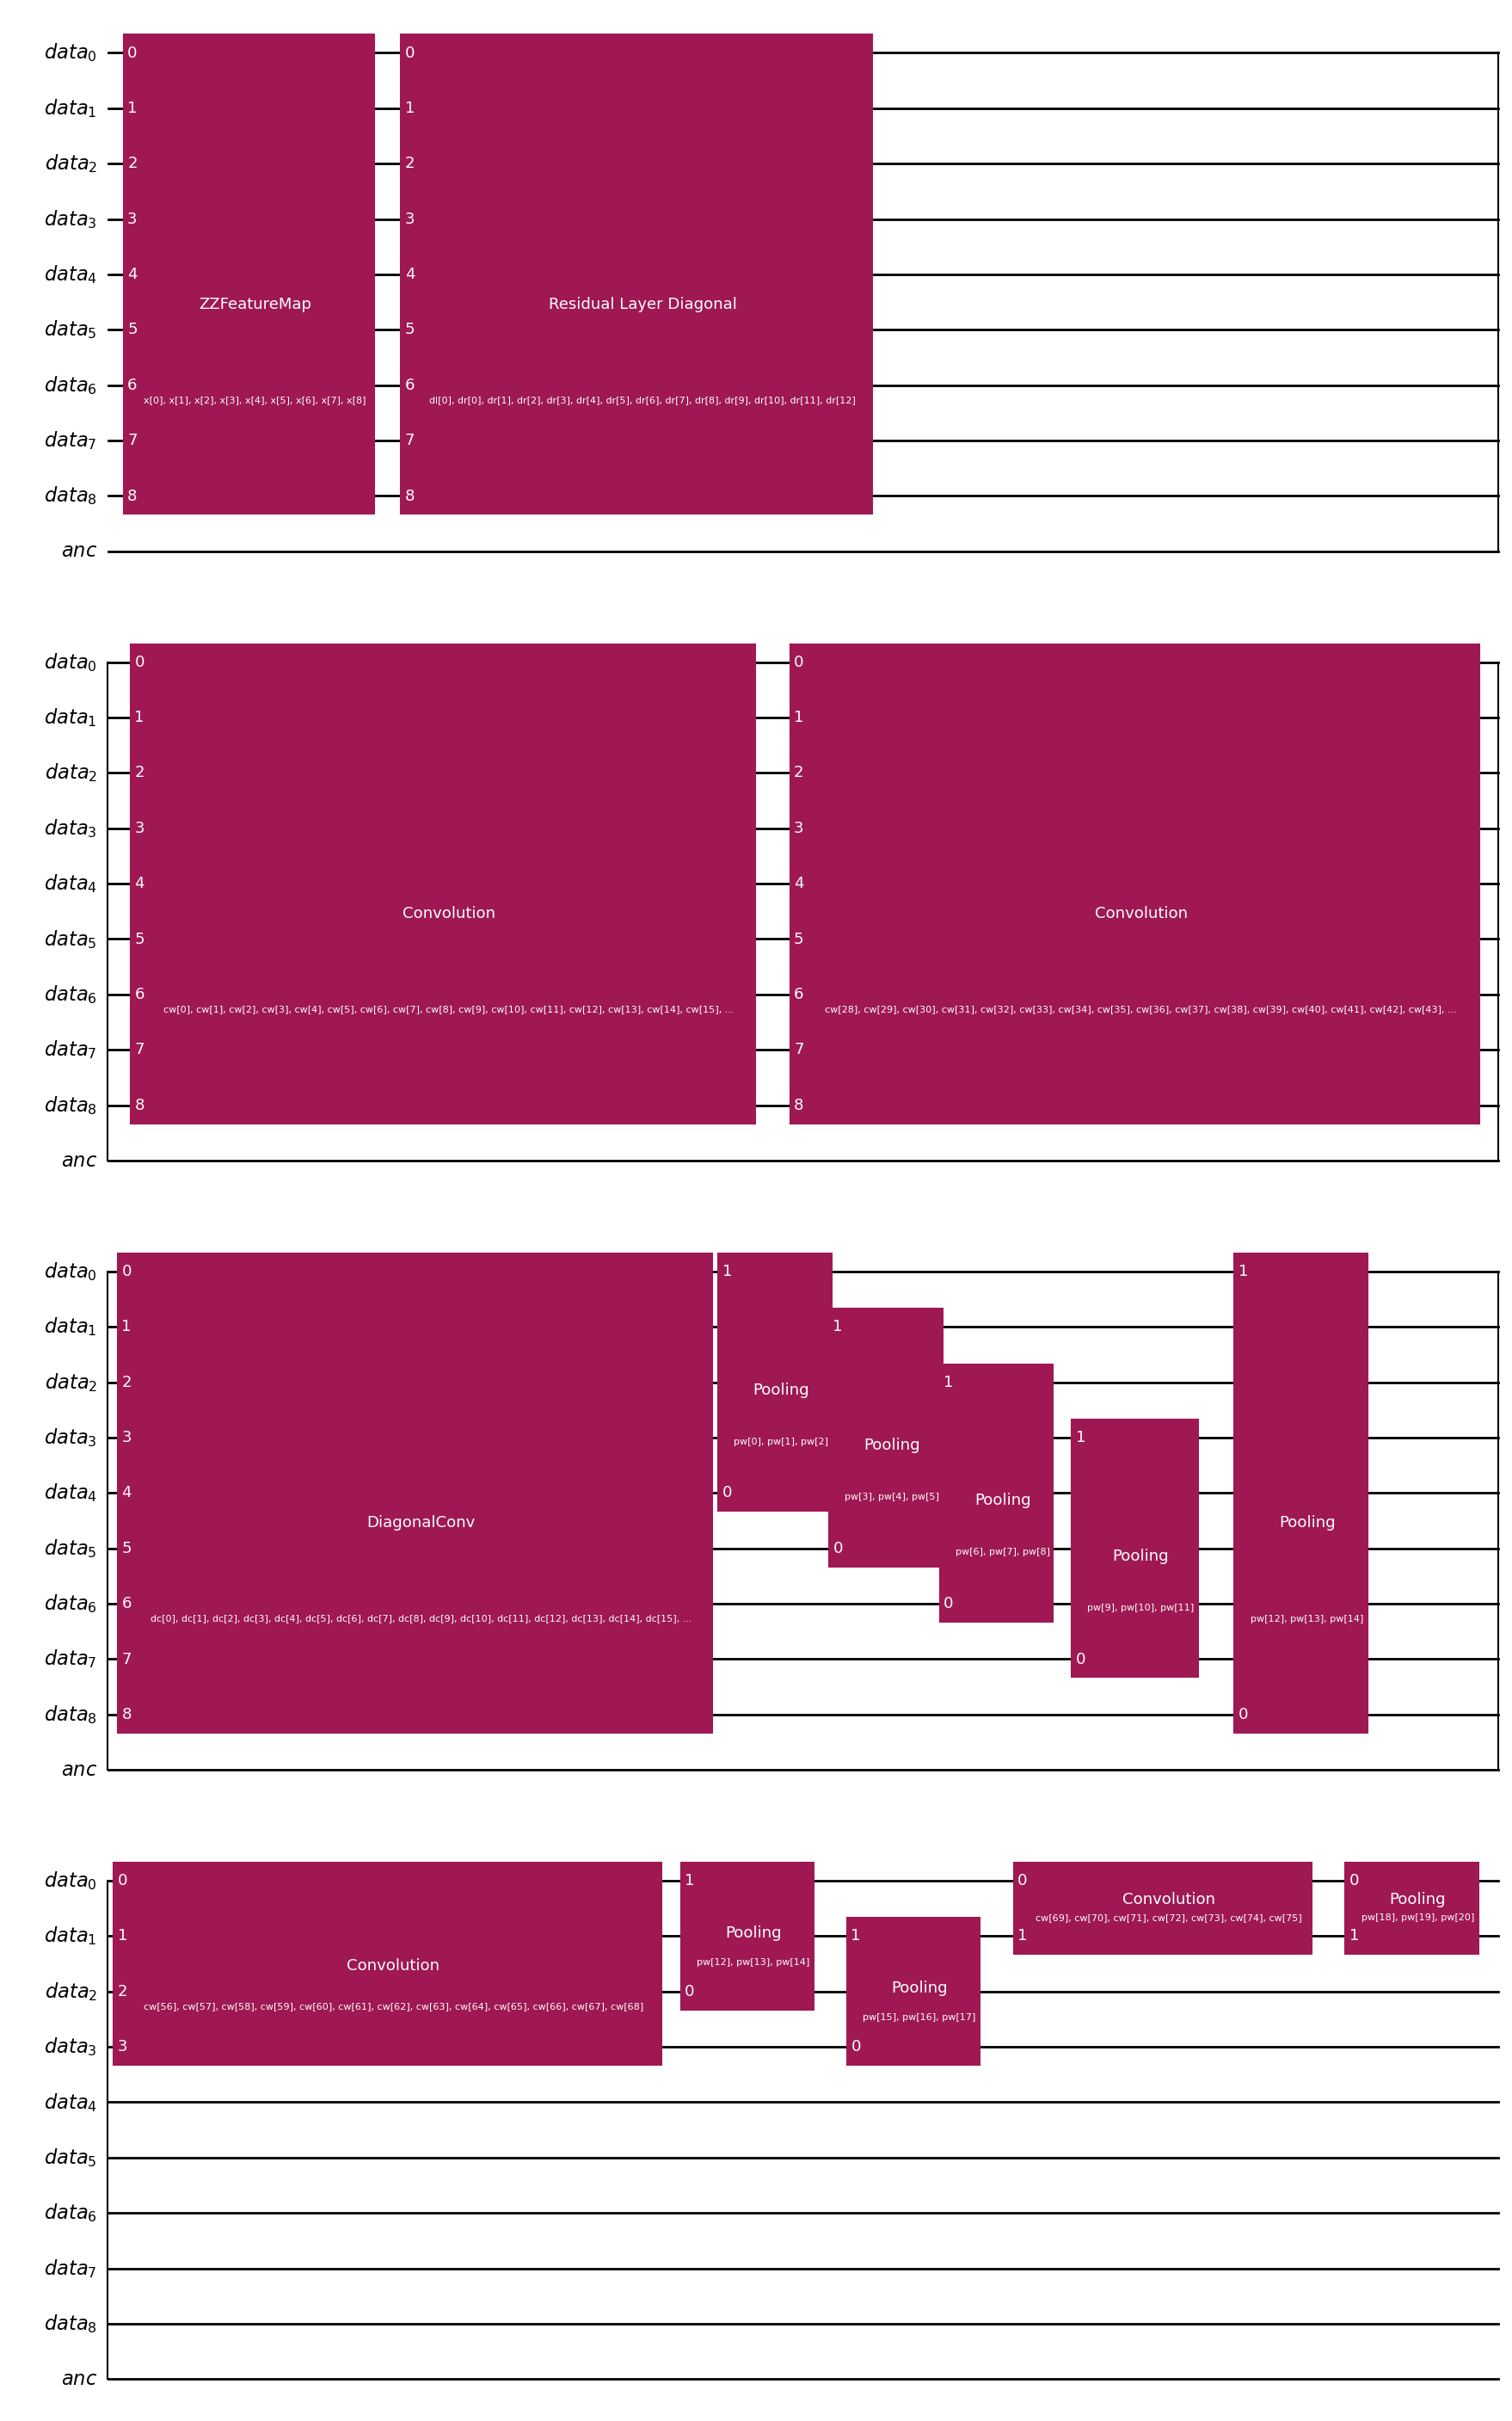

In [39]:
# Build QCNN circuit
def build_qcnn():
    data = QuantumRegister(9, 'data')
    ancilla = QuantumRegister(1, 'anc')
    qc = QuantumCircuit(data, ancilla)

    # ZZFeatureMap with parameters
    feature_map = ZZFeatureMap(feature_dimension=9, reps=2)
    input_params = feature_map.parameters
    qc.compose(feature_map, qubits=data[:], inplace=True)

    
    
    # Define trainable parameters
    conv_weights = ParameterVector('cw', 76)
    pool_weights = ParameterVector('pw', 21)  # 7 pooling layers, 3 params each = 21
    dconv_weights = ParameterVector("dc", 31)  # 4*3 (for U3) + 1 (for ZZ)

    dres_weights = ParameterVector('dr', 13)
    dl_param = ParameterVector('dl', 1)
    
    # Layer 1 - Diagnol Res Block (4 qubits)
    res_layer = alternating_encoding_with_diagonal_residual(9, dres_weights, dl_param)
    qc.append(res_layer.to_instruction(), data[:])
     # Layer 1 - Convolution (9 qubits)
    conv1 = conv_layer(list(range(9)), conv_weights, 0)
    qc.append(conv1.to_instruction(), data[:])
    
    # Layer 1 - Convolution (9 qubits)
    conv2 = conv_layer(list(range(9)), conv_weights, 28)
    qc.append(conv2.to_instruction(), data[:])

    dc = diagonal_conv_layer(list(range(9)), dconv_weights, 0)
    qc.append(dc.to_instruction(), data[:])

    # Layer 2 - Pooling (9 -> 4)
    pool_pairs = [(4, 0), (5, 1), (6, 2), (7, 3), (8, 0)]
    for i, (ctrl, tgt) in enumerate(pool_pairs):
        idx = i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

   
    # Layer 3 - Convolution (4 qubits)
    conv3 = conv_layer(list(range(4)), conv_weights, 56)
    qc.append(conv3.to_instruction(), data[0:4])

    # Layer 4 - Pooling (4 -> 2)
    pool2_pairs = [(2, 0), (3, 1)]
    for i, (ctrl, tgt) in enumerate(pool2_pairs):
        idx = 12 + i * 3
        pool = pooling_layer(0, 1, pool_weights[idx:idx+3])
        qc.append(pool.to_instruction(), [data[ctrl], data[tgt]])

    # Layer 5 - Convolution (2 qubits)
    conv4 = conv_layer(list(range(2)), conv_weights, 69)
    qc.append(conv4.to_instruction(), data[0:2])

    # Layer 6 - Pooling (2 -> 1)
    pool3 = pooling_layer(1, 0, pool_weights[18:21])
    qc.append(pool3.to_instruction(), [data[0], data[1]])
    full_weight_params =  list(conv_weights) + list(pool_weights) + list(dconv_weights) + list(dres_weights) + list(dl_param)

    return qc, input_params, full_weight_params

qcnn_circuit, input_params, weight_params = build_qcnn()
qcnn_circuit.draw("mpl")

In [40]:
print((input_params))
print(len(weight_params))

ParameterView([ParameterVectorElement(x[0]), ParameterVectorElement(x[1]), ParameterVectorElement(x[2]), ParameterVectorElement(x[3]), ParameterVectorElement(x[4]), ParameterVectorElement(x[5]), ParameterVectorElement(x[6]), ParameterVectorElement(x[7]), ParameterVectorElement(x[8])])
142


In [41]:

observables = SparsePauliOp.from_list([
    ("ZZIIIIIIII", 1),
    ("IZZIIIIIII", 1),
    ("IIZZIIIIII", 1),
    ("IIIZZIIIII", 1),
    ("IIIIZZIIII", 1),
    ("IIIIIZZIII", 1),
    ("IIIIIIZZII", 1),
    ("IIIIIIIZZI", 1),
])
estimator = StatevectorEstimator()
gradient = ParamShiftEstimatorGradient(estimator)

qnn = EstimatorQNN(
    circuit=qcnn_circuit,
    input_params=input_params,
    weight_params=weight_params,
    estimator=estimator,
    observables=observables,
    gradient=gradient
)

initial_point = np.random.rand(qnn.num_weights)
loss_vals = []
batch_size = 16
num_batches = int(np.ceil(len(data) / batch_size))

def callback_graph(weights, loss):
    correct = 0
    for i in range(num_batches):
        batch_data = data[i * batch_size:(i + 1) * batch_size]
        batch_labels = labels[i * batch_size:(i + 1) * batch_size]
    print(f"Loss: {loss:.4f}")
    loss_vals.append(loss)

classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),
    initial_point=initial_point,
    loss="squared_error",
    callback=callback_graph,
)



classifier.fit(data, labels)
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy:.2f}")

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq\\backend\\cython\\checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

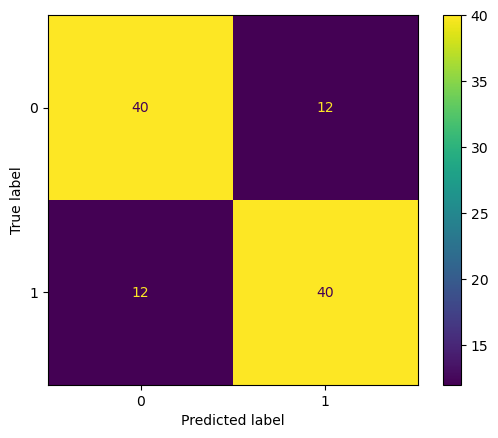

In [15]:
y_pred = classifier.predict(data)
# 5. Build and show confusion matrix
cm = confusion_matrix(labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [17]:
accuracy = classifier.score(data, labels)
print(f"Final Accuracy: {accuracy}")

Final Accuracy: 0.7692307692307693


In [ ]:
# After you predict
f1 = f1_score(labels, y_pred, average='macro')  # or 'micro', 'weighted', etc.
print("F1 Score:", f1)

F1 Score: 0.7692307692307693


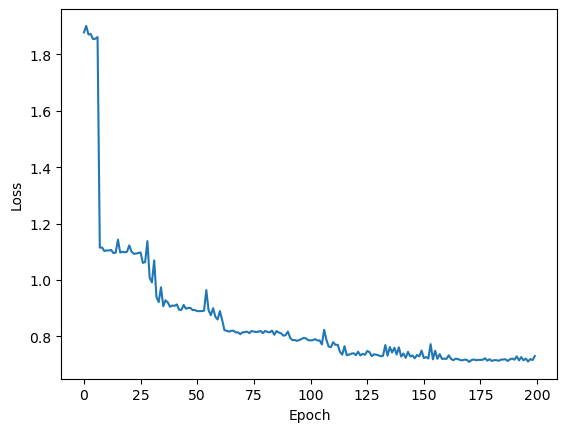

In [16]:
plt.plot(loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [ ]:
predictions = classifier.predict(data)

[[ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]
 [-1.]
 [ 1.]]


In [ ]:
cr = 0
for i in range(104):  # Show first 10 samples
    # print(f"Predicted: {predictions[i]}, Actual: {labels[i]}")
    if(predictions[i] == labels[i]):
      cr += 1
print(cr)

79
